In [115]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./style.css", "r").read()
    return HTML(styles)
css_styling()

<h1 class="h1first">Atomic processes in plasma</h1>

<p class="p1">This Jupyter notebook contains information relating to atomic data, atomic physics, atomic modelling and coding of said processes for collisions inside plasmas.</p>

<div id="divh2first"><h2 class="h2first">Charge exchange</h2></div>

<p class="p2">This section will outline what is involved in implementing charge exchange. An example code implmenting charge exchange can be found below. <p> 

<h3 class="h3first"> Physics </h3>
<p class="p3"> In Charge exchange an electron is transferred from one atom to another. An example is
$$ H + H^{+} \rightarrow H^{+} + H $$
If the 2 interacting atoms are one electron different that this means that the density of each atom is unchanged.   
</p>   
<h3 class="h3next"> Meaning of various quantities </h3>
<p class="p3">The following subsections explains the meaning of various quantities used in the code </p>
<ul>
<li> Weight ($w$)- A macroparticle representing a particular number of physical particles </li>
<li> Deltaweight ($d w $) - Change in the weight of a particle </li>
<li> Ion density ($n_{ions}$) - number density of ions </li>
<li> Time step ($d t$) - Time step interval </li>
<li> Charge exchange rate ($R_{CE}$) - Rate at which charge exchange rate occurs </li>
<li> Fluid picture decribes the ions of the plasma (H<sup>+</sup>) </li>
<li> Particle picture describes the neutrals of the plasma (H) </li>
</ul>

<h3 class="h3next"> Equations for various quantities </h3>

$$ d w = R_{CE} \ w \ n_{ions} \ d t $$

<div id="divh2next"><h2 class="h2next" > Ionise </h2></div>
<p class="p2"> This section will outline what is involved in implementing ionisation <p>

<h3 class="h3first"> Physics </h3>    
<p class="p3">
Electron impact ionisation is where an electron and atom/ion collide resulting in the atom/ion losing an electron, e.g.
$$ e + H \rightarrow 2e + H^{+}$$    
</p>    
<h3 class="h3next"> Meaning of various quantities </h3>
<ul>
<li> Weight ($w$)- A macroparticle representing a particular number of physical particles </li>
</ul>

<div id="divh2next"><h2 class="h2next" > Electron Capture </h2></div>
<h3 class="h3first"> Physics </h3>  
<p class="p3">
Electron capture is where an electron and atom/ion collide resulting in the atom/ion gaining an electron, e.g.
$$ e + H^{+} \rightarrow H $$    
    
</p>   

<h1>Example Code Charge Exchange</h1>

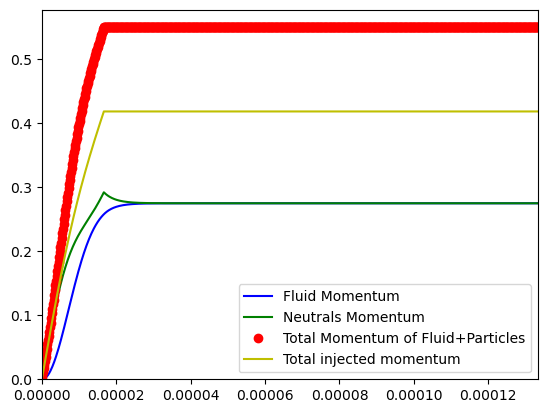

In [91]:
import matplotlib.pyplot as plt #Used for plotting 
import numpy as np #Used for normal distribution
import unittest #Used for unit testing of code

R_CE = 5E-14 #Units m^3 s^-1
w = 1.65E+16 #No units
dt = 1.66667e-07 #Units Seconds
timestep=1 #No units
max_neutrals_density=3.3e18;
max_timesteps=800 #No units
fluid_velocity_sd=0.0

mass_of_single_neutral=1.0 #Nektar units
mass_of_single_ion=1.0 #Nektar units

fluid_velocity=np.full(max_timesteps+1,0.0) #Nektar Units
fluid_momentum=np.full(max_timesteps+1,0.0) #Nektar Units

neutrals_velocity=np.full(max_timesteps+1,0.5) #Nektar Units
ion_density=max_neutrals_density #Units SI

k_n_to_nektar=3.33333e-19 #Conversion factor from SI to nektar units
dt_nektar=0.005 #Timestep in Nektar units
neutrals_momentum=np.zeros(max_timesteps+1) #Nektar units
time=np.zeros(max_timesteps+1) #Time in Nektar Units
total_momentum_injected=np.zeros(max_timesteps+1) #Nektar Units

particle_injection_timestep_cutoff=100 #Timestep at which code stops injecting particles

while timestep <= max_timesteps:
    if timestep <= particle_injection_timestep_cutoff:
        neutrals_density=timestep*max_neutrals_density/float(particle_injection_timestep_cutoff)
        
    if timestep<= particle_injection_timestep_cutoff:   
        injected_number_particles=(max_neutrals_density/float(particle_injection_timestep_cutoff))
        dp_injected=mass_of_single_neutral*injected_number_particles*neutrals_velocity[timestep]*k_n_to_nektar
        total_momentum_injected[timestep]=total_momentum_injected[timestep-1] + dp_injected           
    if timestep>particle_injection_timestep_cutoff:
        total_momentum_injected[timestep]=total_momentum_injected[timestep-1]
        
    time[timestep]=timestep*dt  
    #Units dw
    #=[m^3 s^-1]*[unitless]*[m^-3]*[s]
    #=[Unitless] 
    dw = R_CE*w*neutrals_density*dt
    
    #Units neutrals_momentum (nektar_units)
    #=[nektar_units_mass]*[nektar_units_velocity]*[SI_units_number_density]*[conversion_factor_SI_to_nektar_for_density]
    neutrals_momentum[timestep]=mass_of_single_neutral*neutrals_velocity[timestep]*neutrals_density*k_n_to_nektar
    
    #Units fluid_velocity (nektar_units)
    #=[nektar_units_momentum]*[1/nektar_mass_units]*[1/(SI_units_number_density)]*[1/(conversion_factor_SI_to_nektar_for_density)]
    fluid_velocity[timestep]=fluid_momentum[timestep]/(mass_of_single_ion*ion_density*k_n_to_nektar)   
    random_fluid_velocity=np.random.normal(fluid_velocity[timestep],fluid_velocity_sd,size=None)
    
    #Units dp_tot
    #=[unitless]*[nektar_units_mass]*[nektar_units_velocity] 
    dp_tot = dw*(- mass_of_single_neutral*neutrals_velocity[timestep] + mass_of_single_ion*random_fluid_velocity);
    
    if timestep < max_timesteps:
        neutrals_velocity[timestep+1]=neutrals_velocity[timestep] + dp_tot/w
        fluid_momentum[timestep+1]=fluid_momentum[timestep] - dp_tot*k_n_to_nektar/dt_nektar
    timestep=timestep+1


plt.plot(time, fluid_momentum,'b', label="Fluid Momentum")  
plt.plot(time, neutrals_momentum,'g', label="Neutrals Momentum")  

plt.plot(time, neutrals_momentum+fluid_momentum,'ro', label="Total Momentum of Fluid+Particles")  
plt.plot(time, total_momentum_injected,'y', label="Total injected momentum")  

plt.axvline(x = 100, color = 'k', linestyle='--')
plt.xlim([0, max_timesteps*dt])
plt.ylim(bottom=0)
plt.legend(loc="lower right")
plt.show()    

 # Example Code Ionisation

In [95]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sc

In [96]:
x = np.array([1, 2, 3, 4])
print(sc.exp1(x))

[0.21938393 0.04890051 0.01304838 0.00377935]


<h1 class="h1first">Atomic Databases and Atomic Data</h1>
<div id="divh2first"><h2 class="h2first">Atomic Databases</h2></div>
<p class="p2">
This section will outline various databases of atomic data    
<ul>
    <li> <a href="https://www.adas.ac.uk/about.php"> ADAS</a> </li>   
    <li> <a href="https://open.adas.ac.uk">OpenADAS </a> </li>
    <li> <a href="https://www-amdis.iaea.org/ALADDIN/">ALADDIN</a></li>   
</ul>
</p>    
<div id="divh2first"><h2 class="h2next" >Atomic Data</h2></div>
<p class="p2">
This section will outline various atomic data, analytical formula which have been used in NESO.    
<ul>
<li> <a href="https://scientific-publications.ukaea.uk/wp-content/uploads/CLM-R137.pdf">Charge Exchange Data</a> </li>
</ul>    
</p>    